In [13]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from scipy.sparse import hstack
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, cohen_kappa_score ,classification_report, accuracy_score
import joblib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 63.8 MB/s eta 0:00:00


In [4]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Data Cleaning

In [8]:

# --- 1. ARABIC PREPROCESSING UTILITIES ---

# Comprehensive list of Arabic diacritics (Harakat) to be removed
ARABIC_DIACRITICS = re.compile(r'[\u064B-\u0652]')

def remove_diacritics(text):
    """Removes Arabic diacritics (Harakat) from text."""
    return ARABIC_DIACRITICS.sub('', text)

def remove_non_alpha(text):
    """Removes non-alphanumeric characters except spaces."""
    # Keeps Arabic letters, English letters (if any), and spaces
    return re.sub(r'[^\w\s]', '', text)

def clean_text(text):
    """Applies basic cleaning and normalization."""
    if pd.isna(text) or not text:
        return ""
    text = str(text).lower()
    text = remove_diacritics(text)
    text = remove_non_alpha(text)
    return re.sub(r'\s+', ' ', text).strip() # Normalize whitespace

def calculate_morph_complexity(tokens_col):
    """
    Calculates the average number of morphological tokens (D3Tok/D3Lex) per original word.
    A higher value indicates more complex agglutination.
    """
    if pd.isna(tokens_col) or not tokens_col:
        return 1.0 # Default complexity for empty/missing data

    original_words = tokens_col.split()
    total_morph_units = 0
    total_words = 0

    for word in original_words:
        # Check for the '+' delimiter, which separates morphological units
        morph_units = word.count('+') + 1
        total_morph_units += morph_units
        total_words += 1

    return total_morph_units / total_words if total_words > 0 else 1.0


In [ ]:
df.head()

,ID,Sentence,Word_Count,Word,Lex,D3Tok,D3Lex,Readability_Level,Document,Source,Book,Author,Domain,Text_Class,Dataset_Source,Readability_Level_Encoded,Clean_Lex,Avg_Lex_Length,Lexical_Density,Morph_Complexity
0,10102480006,انظر يا فهمان..,5,انظر يا فهمان . .,نظر يا فهمان . .,انظر يا فهمان . .,نظر يا فهمان . .,2,BAREC_Majed_1686_2011_027.txt,Majed,Edition: 1686,#,Arts & Humanities,Foundational,BAREC,1,نظر يا فهمان,3.333333,1.0,1.000000
1,30400010076,تشجع الدولة الديمقراطية القائمة على المشاركة ع...,11,تشجع الدولة الديمقراطية القائمة على المشاركة ع...,شجع دولة ديمقراطي قائم على مشاركة على مستوى سل...,تشجع ال+ دولة ال+ ديمقراطية ال+ قائمة على ال+ ...,شجع ال+ دولة ال+ ديمقراطي ال+ قائم على ال+ مشا...,5,BAREC_MCWC_Algeria_001.txt,Constitutions,Algeria's Constitution,#,Social Sciences,Specialized,BAREC,4,شجع دولة ديمقراطي قائم على مشاركة على مستوى سل...,4.400000,0.9,1.352941
2,30500230021,رسولُ اللّهِ والحياةُ الاجتماعيّةُ,4,رسول الله والحياة الاجتماعية,رسول الله حياة ٱجتماعي,رسول الله و+ ال+ حياة ال+ اجتماعية,رسول الله و+ ال+ حياة ال+ ٱجتماعي,3,BAREC_Curriculum_12_slm_t1_u01_001.txt,Emarati Curriculum,Grade 12 Islamic Studies,#,Arts & Humanities,Specialized,BAREC,2,رسول الله حياة ٱجتماعي,4.750000,1.0,1.428571
3,20200330009,س: ما هي عاصمة ألبانيا؟ (أ) تيرانا (ب) ساوتو...,19,س : ما هي عاصمة ألبانيا ؟ ( أ ) تيرانا ( ب ) س...,س : ما هي عاصمة ألبانيا ؟ ( أ ) تيرانا ( ب ) س...,س : ما هي عاصمة ألبانيا ؟ ( أ ) تيرانا ( ب ) س...,س : ما هي عاصمة ألبانيا ؟ ( أ ) تيرانا ( ب ) س...,4,BAREC_ArabicMMLU_Group_16_010.txt,ArabicMMLU,#,#,Arts & Humanities,Advanced,BAREC,3,س ما هي عاصمة ألبانيا أ تيرانا ب ساوتومي ج تمندو,3.454545,1.0,1.050000
4,20101750010,وظلت مأهولة لمدة 700 سنة أخرى على الأقل، كجماع...,18,"وظلت مأهولة لمدة 700 سنة أخرى على الأقل , كجما...","ظل مأهول مدة 700 سنة أخرى على أقل , جماعة مسيح...",و+ ظلت مأهولة ل+ مدة 700 سنة أخرى على ال+ أقل ...,"و+ ظل مأهول ل+ مدة 700 سنة أخرى على ال+ أقل , ...",5,BAREC_Wikipedia_وليلي_001.txt,Wikipedia,Volubilis,#,Social Sciences,Advanced,BAREC,4,ظل مأهول مدة 700 سنة أخرى على أقل جماعة مسيحي ...,4.066667,1.0,1.217391


In [9]:
# --- 2. DATA LOADING AND INITIAL CLEANING ---

FILEPATH = '/content/drive/MyDrive/bayyin_dataset.csv'

df = pd.read_csv(FILEPATH)


# Drop rows where the target or essential feature columns are missing
df.dropna(subset=['Sentence', 'Lex', 'Word_Count', 'Readability_Level'], inplace=True)

# Encode the target variable (Readability_Level) to integers (0 to 5)
# XGBoost requires integer labels starting from 0 for multi-class classification
target_le = LabelEncoder()
df['Readability_Level_Encoded'] = target_le.fit_transform(df['Readability_Level'])
print(f"Readability Levels Mapped to: {dict(zip(target_le.classes_, target_le.transform(target_le.classes_)))}")

# Apply cleaning to the text columns
df['Clean_Lex'] = df['Lex'].apply(clean_text)


Readability Levels Mapped to: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(6): np.int64(5)}


# Feature Engineering

In [10]:
# --- A. Core Linguistic/Statistical Features ---

# 1. Word Count (already present, but ensure type)
df['Word_Count'] = df['Word_Count'].astype(int)

# 2. Average Word Length (using the cleaned root/lemma column)
df['Avg_Lex_Length'] = df['Clean_Lex'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x else 0)

# 3. Lexical Density (Type-Token Ratio using Lexemes)
df['Lexical_Density'] = df['Clean_Lex'].apply(
    lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0
)

# 4. Morphological Complexity (using D3Tok column)
# This captures how many morphemes (pre-/suf-fixes) are attached to each word
df['Morph_Complexity'] = df['D3Tok'].apply(calculate_morph_complexity)



# --- B. Text Vectorization Features (TF-IDF) ---

# Use the 'Clean_Lex' column (lemmas/roots) for better semantic representation
# Note: Using the top 5000 features. Adjust this number based on memory/performance trade-offs.
print("\nFitting TF-IDF Vectorizer...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2) # Use unigrams and bigrams
)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Clean_Lex'])
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")


Fitting TF-IDF Vectorizer...
TF-IDF Matrix Shape: (46410, 5000)


In [11]:
# --- 4. DATA PREPARATION FOR XGBOOST ---
from scipy.sparse import hstack
# Define the numerical and categorical feature matrix
X_stats = df[['Word_Count', 'Avg_Lex_Length', 'Lexical_Density', 'Morph_Complexity']].values

# FIX: Explicitly convert the dense matrix to a numeric type (float64)
# to prevent Pandas from creating an 'object' array, which hstack rejects.
X_stats_numeric = X_stats.astype(np.float64)

# Combine all feature matrices: Statistical + Categorical + TF-IDF
# hstack is used to combine sparse and dense matrices efficiently
X = hstack([
    X_stats_numeric, # <-- Use the numeric array
    tfidf_matrix
]).tocsr()

y = df['Readability_Level_Encoded']

print(f"\nFinal Feature Matrix Shape (X): {X.shape}")
print(f"Target Vector Shape (y): {y.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y # Stratify ensures equal distribution of readability levels
)


Final Feature Matrix Shape (X): (46410, 5004)
Target Vector Shape (y): (46410,)


# Use Grid Search for Fine-Tuning

In [ ]:
# --- HYPERPARAMETER FINE-TUNING  ---

print("\nStarting XGBoost Hyperparameter Fine-Tuning (Grid Search)...")
start_time = time.time()

# Determine the number of classes for the multi-class objective
num_classes = len(target_le.classes_)

# 1. Define the XGBoost model to tune
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

# 2. Define the grid of parameters to search
# NOTE: This grid is relatively small to keep the runtime manageable.
# For deeper tuning, you would expand these ranges.
param_grid = {
    'n_estimators': [200, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 7]
}

# 3. Initialize GridSearchCV
# Scoring by 'accuracy' (default for classification). cv=3 means 3-fold cross-validation.
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2 # Show progress
)

# 4. Run the grid search on the training data
grid_search.fit(X_train, y_train)

# The best model found during the search
best_xgb_model = grid_search.best_estimator_
end_time = time.time()

print(f"\nGrid Search Complete! Time taken: {end_time - start_time:.2f} seconds")
print(f"Best Parameters Found: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")




Starting XGBoost Hyperparameter Fine-Tuning (Grid Search)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:13:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time= 2.2min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:15:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time= 2.1min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:17:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time= 2.1min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:19:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=300; total time= 2.9min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:22:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=300; total time= 2.8min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:25:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=300; total time= 2.8min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:28:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=200; total time= 3.6min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:31:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=200; total time= 3.6min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:35:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=200; total time= 3.6min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:39:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=300; total time= 4.7min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:43:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=300; total time= 4.8min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:48:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=300; total time= 4.7min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:53:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time= 1.8min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:55:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time= 1.8min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:56:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time= 1.8min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:58:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=300; total time= 2.5min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:01:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=300; total time= 2.5min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:03:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=300; total time= 2.5min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:06:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time= 2.9min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:09:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time= 3.0min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:11:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time= 2.9min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:14:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=300; total time= 4.0min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:18:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=300; total time= 4.0min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:22:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=300; total time= 3.9min


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:26:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Grid Search Complete! Time taken: 4773.47 seconds
Best Parameters Found: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Best Cross-Validation Accuracy: 0.5628


In [ ]:
# --- 6. EVALUATION (Basic Metrics) ---

from sklearn.metrics import classification_report, accuracy_score

# Predict on the test set
y_pred = best_xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.4f}")

target_names_list = [str(c) for c in target_le.classes_]
# Print a detailed classification report
print("\nClassification Report (Test Set):")
# Use the original class names for the report
report = classification_report(
    y_test,
    y_pred,
    target_names=target_names_list,
    digits=4
)
print(report)


Test Set Accuracy: 0.5629

Classification Report (Test Set):
              precision    recall  f1-score   support

           1      0.578     0.824     0.679      1547
           2      0.553     0.558     0.555      1480
           3      0.607     0.500     0.548      1547
           4      0.483     0.332     0.394      1547
           5      0.574     0.655     0.612      1547
           6      0.516     0.304     0.382       326

    accuracy                          0.563      7994
   macro avg      0.552     0.529     0.528      7994
weighted avg      0.557     0.563     0.551      7994



# Training with TF-IDF

TF-IDF only

In [ ]:
X= tfidf_matrix.tocsr()
y = df['Readability_Level_Encoded'].values


X_train_Tfidf, X_test_Tfidf, y_train_Tfidf, y_test_Tfidf = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y # Stratify ensures equal distribution of readability levels
)

print("\nTraining XGBoost with TF-IDF ...")
xgb_Tfidf = XGBClassifier(
    learning_rate= 0.1,
    max_depth = 7,
    n_estimators = 300,
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb_Tfidf.fit(X_train_Tfidf, y_train_Tfidf)

# --- Step 4: Evaluate ---
y_pred_Tfidf = xgb_Tfidf.predict(X_test_Tfidf)
print("\n Model Evaluation (TF-IDF):")
print(classification_report(y_test_Tfidf, y_pred_Tfidf))
print("Accuracy ( TF-IDF):", accuracy_score(y_test_Tfidf, y_pred_Tfidf))


Training XGBoost with TF-IDF ...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:24:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Model Evaluation (TF-IDF):
              precision    recall  f1-score   support

           0       0.47      0.89      0.62      1547
           1       0.52      0.46      0.49      1547
           2       0.51      0.48      0.49      1547
           3       0.44      0.24      0.31      1547
           4       0.54      0.49      0.51      1547
           5       0.65      0.56      0.60      1547

    accuracy                           0.52      9282
   macro avg       0.52      0.52      0.50      9282
weighted avg       0.52      0.52      0.50      9282

Accuracy ( TF-IDF): 0.5185304891187245


In [ ]:
# --- Add Quadratic Weighted Kappa (QWK) for TF-IDF Only Model ---
qwk_tfidf = cohen_kappa_score(y_test_Tfidf, y_pred_Tfidf, weights='quadratic')
print(f"Quadratic Weighted Kappa (TF-IDF): {qwk_tfidf:.4f}")

Quadratic Weighted Kappa (TF-IDF): 0.6478


In [ ]:
print(f"\nFinal Feature Matrix Shape (X): {X.shape}")
print(f"Target Vector Shape (y): {y.shape}")


Final Feature Matrix Shape (X): (46410, 5000)
Target Vector Shape (y): (46410,)


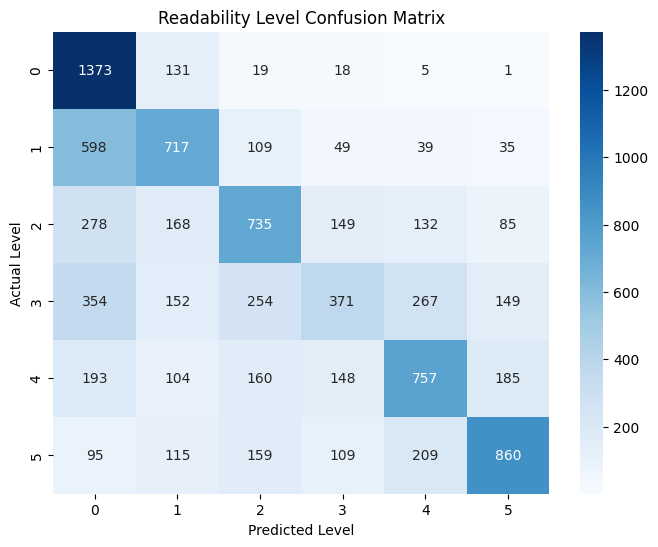

In [ ]:
cm = confusion_matrix(y_test_Tfidf, y_pred_Tfidf)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Level")
plt.ylabel("Actual Level")
plt.title("Readability Level Confusion Matrix")
plt.show()

Statistical + TF-IDF

In [14]:
# Combine all feature matrices: Statistical + TF-IDF
# hstack is used to combine sparse and dense matrices efficiently
X = hstack([
    X_stats_numeric, # <-- Use the numeric array
    tfidf_matrix
]).tocsr()

y = df['Readability_Level_Encoded']

print(f"\nFinal Feature Matrix Shape (X): {X.shape}")
print(f"Target Vector Shape (y): {y.shape}")

# Split the data into training and testing sets
X_train_stats_Tfidf, X_test_stats_Tfidf, y_train_stats_Tfidf, y_test_stats_Tfidf = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y # Stratify ensures equal distribution of readability levels
)
print("\nTraining XGBoost with Statistcal and TF-IDF ...")
xgb_stats_Tfidf = XGBClassifier(
    learning_rate= 0.1,
    max_depth = 7,
    n_estimators = 300,
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb_stats_Tfidf.fit(X_train_stats_Tfidf, y_train_stats_Tfidf)

# --- Step 4: Evaluate ---
y_pred_stats_Tfidf = xgb_stats_Tfidf.predict(X_test_stats_Tfidf)
print("\n Model Evaluation (Statistcal and TF-IDF):")
print(classification_report(y_test_stats_Tfidf, y_pred_stats_Tfidf,digits=4))
print("Accuracy (Statistcal and TF-IDF):", accuracy_score(y_test_stats_Tfidf, y_pred_stats_Tfidf))


Final Feature Matrix Shape (X): (46410, 5004)
Target Vector Shape (y): (46410,)

Training XGBoost with Statistcal and TF-IDF ...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:58:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Model Evaluation (Statistcal and TF-IDF):
              precision    recall  f1-score   support

           0     0.5501    0.8274    0.6608      1547
           1     0.5184    0.5656    0.5410      1547
           2     0.5203    0.4971    0.5084      1547
           3     0.4665    0.2521    0.3273      1547
           4     0.5418    0.5611    0.5513      1547
           5     0.6617    0.5779    0.6170      1547

    accuracy                         0.5469      9282
   macro avg     0.5431    0.5469    0.5343      9282
weighted avg     0.5431    0.5469    0.5343      9282

Accuracy (Statistcal and TF-IDF): 0.5468648998060762


In [15]:
# --- Add Quadratic Weighted Kappa (QWK) for Statistical + TF-IDF Model ---
qwk_stats_tfidf = cohen_kappa_score(y_test_stats_Tfidf, y_pred_stats_Tfidf, weights='quadratic')
print(f"Quadratic Weighted Kappa (Statistical + TF-IDF): {qwk_stats_tfidf:.4f}")

Quadratic Weighted Kappa (Statistical + TF-IDF): 0.6956


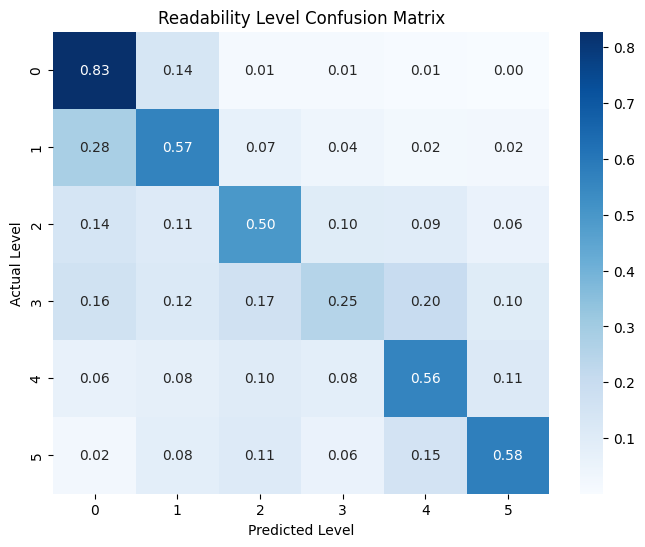

In [17]:
cm = confusion_matrix(y_test_stats_Tfidf, y_pred_stats_Tfidf,normalize='true')
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues') # Changed fmt='d' to fmt='.2f'
plt.xlabel("Predicted Level")
plt.ylabel("Actual Level")
plt.title("Readability Level Confusion Matrix")
plt.show()

# Training with Word2vec

Word2Vec only

In [18]:
# Word2Vec Embeddings with XGBoost

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np

print("\nTraining Word2Vec model...")

# Tokenize the sentences
tokenized_sentences = [word_tokenize(text) for text in df['Sentence'].astype(str)]

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=300,   # you can try 200 or 300 for richer vectors
    window=5,
    min_count=2,
    workers=4,
    sg=1               # Skip-gram (1) usually works better for semantics
)

# Function to compute average Word2Vec embedding for each document
def get_avg_vector(tokens, model, vector_size=300):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# Apply to all sentences
X_w2v = np.array([get_avg_vector(tokens, w2v_model, 300) for tokens in tokenized_sentences])
y_w2v = df['Readability_Level_Encoded'].values


Training Word2Vec model...


In [ ]:
# Split the dataset
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y_w2v, test_size=0.2, random_state=42)

# Train XGBoost model on Word2Vec embeddings
print("\nTraining XGBoost with Word2Vec features...")
xgb_w2v = XGBClassifier(
    learning_rate= 0.1,
    max_depth = 7,
    n_estimators = 300,
    objective='multi:softmax',
    num_class=len(np.unique(y_w2v)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb_w2v.fit(X_train_w2v, y_train_w2v)

# Evaluate
y_pred_w2v = xgb_w2v.predict(X_test_w2v)
print("\n Word2Vec Model Evaluation:")
print(classification_report(y_test_w2v, y_pred_w2v))
print("Accuracy (Word2Vec):", accuracy_score(y_test_w2v, y_pred_w2v))



Training Word2Vec model...

Training XGBoost with Word2Vec features...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:47:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Word2Vec Model Evaluation:
              precision    recall  f1-score   support

           0       0.53      0.64      0.58      1559
           1       0.47      0.43      0.45      1552
           2       0.39      0.37      0.38      1543
           3       0.31      0.23      0.26      1519
           4       0.49      0.50      0.49      1589
           5       0.58      0.66      0.62      1520

    accuracy                           0.47      9282
   macro avg       0.46      0.47      0.46      9282
weighted avg       0.46      0.47      0.46      9282

Accuracy (Word2Vec): 0.4725274725274725


In [ ]:
# --- Add Quadratic Weighted Kappa (QWK) for Word2Vec Only Model ---
qwk_w2v = cohen_kappa_score(y_test_w2v, y_pred_w2v, weights='quadratic')
print(f"Quadratic Weighted Kappa (Word2Vec): {qwk_w2v:.4f}")

Quadratic Weighted Kappa (Word2Vec): 0.6567


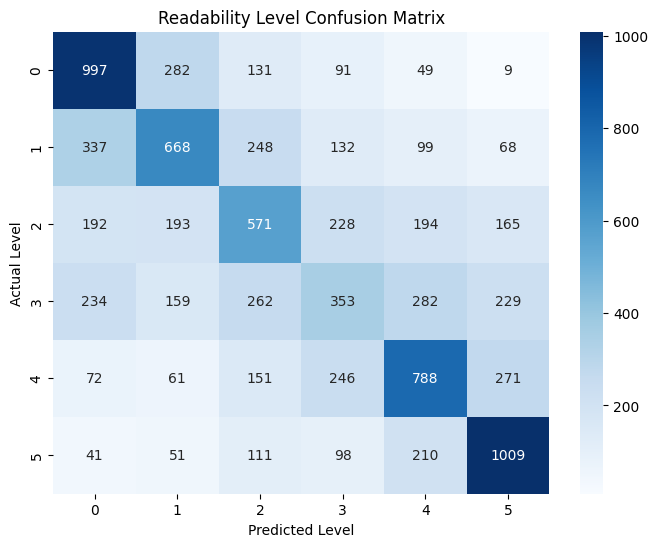

In [ ]:
cm = confusion_matrix(y_test_w2v, y_pred_w2v)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Level")
plt.ylabel("Actual Level")
plt.title("Readability Level Confusion Matrix")
plt.show()

Statistical + Word2Ve

In [19]:
# Combine Statistical + Word2Vec Features


# Ensure all have the same number of samples
X_combined = np.hstack([X_stats, X_w2v])
y_combined = df['Readability_Level_Encoded'].values

print(f"\n Combined feature matrix shape: {X_combined.shape}")

# --- Step 3: Split and Train XGBoost ---
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42
)

print("\nTraining XGBoost with Statistical and Word2vec...")
xgb_combined = XGBClassifier(
    learning_rate= 0.1,
    max_depth = 7,
    n_estimators = 300,
    objective='multi:softmax',
    num_class=len(np.unique(y_combined)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb_combined.fit(X_train_c, y_train_c)

# --- Step 4: Evaluate ---
y_pred_combined = xgb_combined.predict(X_test_c)
print("\n Model Evaluation:(Statistical and Word2vec)")
print(classification_report(y_test_c, y_pred_combined, digits=4))
print("Accuracy (Statistical and Word2vec):", accuracy_score(y_test_c, y_pred_combined))




 Combined feature matrix shape: (46410, 304)

Training XGBoost with Statistical and Word2vec...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:11:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Model Evaluation:(Statistical and Word2vec)
              precision    recall  f1-score   support

           0     0.5688    0.7402    0.6433      1559
           1     0.5140    0.5335    0.5236      1552
           2     0.4446    0.4290    0.4367      1543
           3     0.3734    0.2330    0.2870      1519
           4     0.5605    0.5280    0.5437      1589
           5     0.6183    0.6947    0.6543      1520

    accuracy                         0.5271      9282
   macro avg     0.5132    0.5264    0.5147      9282
weighted avg     0.5137    0.5271    0.5154      9282

Accuracy (Statistical and Word2vec): 0.5271493212669683


In [ ]:
# --- Add Quadratic Weighted Kappa (QWK) for Statistical + Word2Vec Model ---
qwk_stats_w2v = cohen_kappa_score(y_test_c, y_pred_combined, weights='quadratic')
print(f"Quadratic Weighted Kappa (Statistical + Word2Vec): {qwk_stats_w2v:.4f}")

Quadratic Weighted Kappa (Statistical + Word2Vec): 0.7165


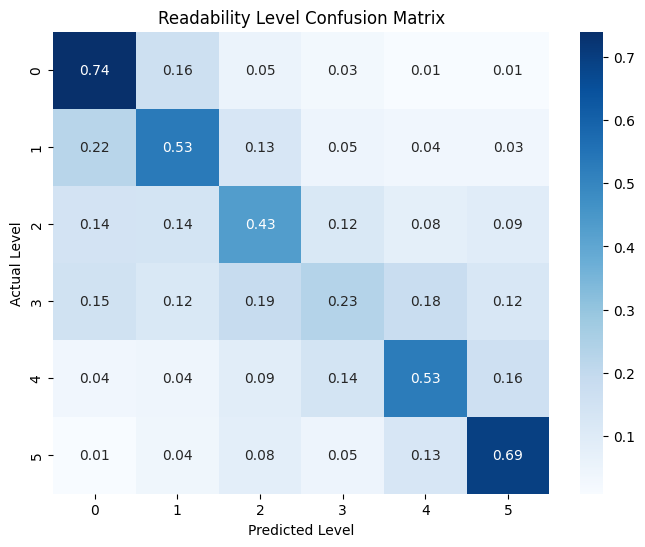

In [20]:
cm = confusion_matrix(y_test_c, y_pred_combined,normalize='true')
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel("Predicted Level")
plt.ylabel("Actual Level")
plt.title("Readability Level Confusion Matrix")
plt.show()

In [ ]:

# --- FEATURE IMPORTANCE ---
# Note: Feature importance for sparse matrices is complex


print("\nTop Feature Importances (Non-TFIDF Features):")
feature_names_stats = ['Word_Count', 'Avg_Lex_Length', 'Lexical_Density', 'Morph_Complexity']
# XGBoost feature importance array includes all features (stats, cats, tfidf)
importances = xgb_stats_Tfidf.feature_importances_

# Get importances for the first N statistical/categorical features
stats_cat_importances = importances[:len(feature_names_stats)]

# Create a Series for easy sorting and display
importance_df = pd.Series(
    stats_cat_importances,
    index=feature_names_stats
).sort_values(ascending=False)

print(importance_df)


# import joblib
# joblib.dump(xgb_model, 'readability_xgb_model.pkl')


Top Feature Importances (Non-TFIDF Features):
Word_Count          0.003729
Lexical_Density     0.000973
Morph_Complexity    0.000480
Avg_Lex_Length      0.000453
dtype: float32


# AraBERT Feature Extraction

In [21]:
# Load the data splits
X_train_pkl, X_test_pkl, y_train_pkl, y_test_pkl = joblib.load("train_test_split.pkl")

In [22]:

print("\nTraining XGBoost with pkl file..")
xgb_pkl = XGBClassifier(
    learning_rate= 0.1,
    max_depth = 7,
    n_estimators = 300,
    objective='multi:softmax',
    num_class=6,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb_pkl.fit(X_train_pkl, y_train_pkl)




Training XGBoost with pkl file..


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:18:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None, num_class=6, ...)

In [23]:
# --- Step 4: Evaluate ---

y_pred_pkl = xgb_pkl.predict(X_test_pkl)
print("\n Model Evaluation:(pkl)")
print(classification_report(y_test_pkl, y_pred_pkl,digits=4))
print("Accuracy (pkl):", accuracy_score(y_test_pkl, y_pred_pkl))


 Model Evaluation:(pkl)
              precision    recall  f1-score   support

           0     0.6394    0.7589    0.6941      1547
           1     0.5849    0.6102    0.5973      1547
           2     0.4629    0.4518    0.4573      1547
           3     0.4319    0.3381    0.3793      1547
           4     0.5982    0.6044    0.6013      1547
           5     0.7784    0.7789    0.7787      1547

    accuracy                         0.5904      9282
   macro avg     0.5826    0.5904    0.5846      9282
weighted avg     0.5826    0.5904    0.5846      9282

Accuracy (pkl): 0.590390002154708


In [ ]:
# --- Add Quadratic Weighted Kappa (QWK) for AraBERT (pkl) Model ---
qwk_pkl = cohen_kappa_score(y_test_pkl, y_pred_pkl, weights='quadratic')
print(f"Quadratic Weighted Kappa (AraBERT): {qwk_pkl:.4f}")

Quadratic Weighted Kappa (AraBERT): 0.7937


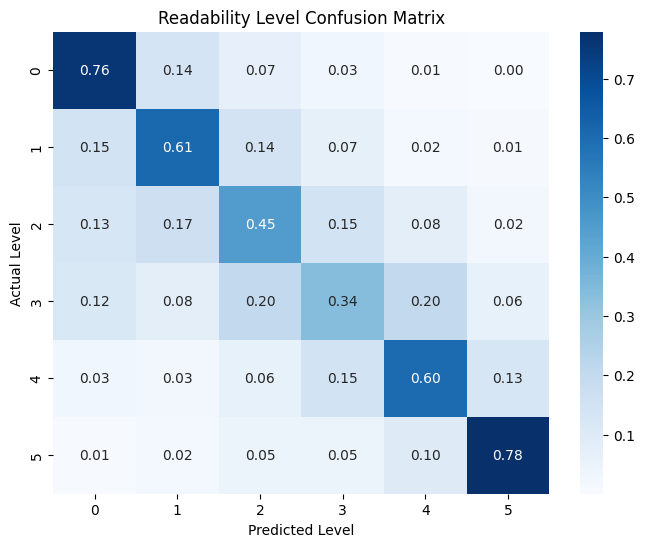

In [24]:


cm = confusion_matrix(y_test_pkl, y_pred_pkl,normalize='true')
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel("Predicted Level")
plt.ylabel("Actual Level")
plt.title("Readability Level Confusion Matrix")
plt.show()

# **Comparision**

In [ ]:
# ... (in the Comparision section)
print("\n Model Comparison:")

# --- Print Accuracy and QWK for all models ---
print(f"\nAccuracy ( TF-IDF): {accuracy_score(y_test_Tfidf, y_pred_Tfidf):.4f}")
print(f"QWK ( TF-IDF): {qwk_tfidf:.4f}")

print(f"\nAccuracy (Statistcal and TF-IDF): {accuracy_score(y_test_stats_Tfidf, y_pred_stats_Tfidf):.4f}")
print(f"QWK (Statistcal and TF-IDF): {qwk_stats_tfidf:.4f}")

print(f"\nAccuracy (Word2Vec): {accuracy_score(y_test_w2v, y_pred_w2v):.4f}")
print(f"QWK (Word2Vec): {qwk_w2v:.4f}")

print(f"\nAccuracy (Statistcal and Word2Vec): {accuracy_score(y_test_c, y_pred_combined):.4f}")
print(f"QWK (Statistcal and Word2Vec): {qwk_stats_w2v:.4f}")

print(f"\nAccuracy (Arabert): {accuracy_score(y_test_pkl, y_pred_pkl):.4f}")
print(f"QWK (Arabert): {qwk_pkl:.4f}")


 Model Comparison:

Accuracy ( TF-IDF): 0.5185
QWK ( TF-IDF): 0.6478

Accuracy (Statistcal and TF-IDF): 0.5469
QWK (Statistcal and TF-IDF): 0.6956

Accuracy (Word2Vec): 0.4725
QWK (Word2Vec): 0.6567

Accuracy (Statistcal and Word2Vec): 0.5267
QWK (Statistcal and Word2Vec): 0.7165

Accuracy (Arabert): 0.5904
QWK (Arabert): 0.7937
